In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [60]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [61]:
# ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
# ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
# ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
# ckpt_path = '../checkpoints/rare-field-129_i52a4aga/'  # new encoding, 0.5 years of GOOG
# ckpt_path = '../checkpoints/autumn-elevator-133_n7oa0i2g/'  # fast encoding
ckpt_path = '../checkpoints/swept-river-135_3kcdrclh/' # after rounding bug fixes

In [62]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=10, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=2, n_layers=6, n_message_layers=2, num_devices=1, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [63]:
# scale down to single GPU, single sample inference
args.bsz = 1
args.num_devices = 1

batchnorm = args.batchnorm

In [64]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [65]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [66]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [67]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [68]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [69]:
dataset_obj = LOBSTER(
    'lobster',
    # data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    data_dir='/nfs/home/peern/LOBS5/data/fast_encoding/',
    # use dummy mask function to get entire sequence
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    use_book_data=True,
    # book_transform=True,  # transform book to image
    use_simple_book=True,  # return (p,v) book and we'll do transorm to volume image later
    msg_seq_len=n_messages + n_eval_messages,
    return_raw_msgs=True,
    #raw_data_dir='/nfs/home/peern/LOBS5/data/raw/',
    n_cache_files=100,  # keep high enough to fit all files in memory
)
dataset_obj.setup()

ds = dataset_obj.dataset_test

In [70]:
ds.message_files

['/nfs/home/peern/LOBS5/data/fast_encoding/GOOG_2023-01-31_34200000_57600000_message_10_proc.npy']

In [71]:
from line_profiler import LineProfiler

In [72]:
import chex
chex.clear_trace_counter()

In [73]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.WARNING)

In [20]:
#%%prun -s cumulative
# profile function calls (not line by line)

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

lp = LineProfiler()
lp.add_function(inference.get_sim_msg)   # add additional function to profile
inference_generate_lp = lp(inference.generate)

rets_gen = []
rets_eval = []
# squared errors of n-step forward return predictions
mid_ret_errs = []
# squared errors of returns using constant mid-price prediction
mid_ret_errs_const = []
# mean abs losses of book levels
book_losses_l1 = []
# benchmark: mean abs losses of book levels (constant prediction)
book_losses_l1_const = []
# wasserstein distance of book levels
book_losses_wass = []
book_losses_wass_const = []
# how many messages had to be discarded
num_errors = []
event_types_gen = []
event_types_eval = []
# inter-arrival times
delta_t_gen = []
delta_t_eval = []

# draw n random samples from dataset for evaluation
n_samples = 500
# how often to repeat generation for each data sample
J_repeats = 1
sample_i = jax.random.choice(
    rng_,
    jnp.arange(len(ds), dtype=jnp.int32),
    shape=(n_samples,),
    replace=False)

# iteratre over all test data
#for i in tqdm(range(len(ds))):
# iterate over random samples
for i in tqdm(sample_i):
    print(f'Processing sample {i}...')

    # 0: encoded message sequence
    # 1: prediction targets (dummy 0 here)
    # 2: book sequence (in Price, Volume format)
    # 3: raw message sequence (pandas df from LOBSTER)
    # 4: initial level 2 book state (before start of sequence)
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))

    # encoded data
    m_seq_inp = m_seq[: seq_len]
    m_seq_eval = m_seq[seq_len: ]
    b_seq_inp = b_seq[: n_messages]
    b_seq_eval = b_seq[n_messages: ]
    # true L2 data
    b_seq_pv_eval = jnp.array(b_seq_pv[n_messages: ])

    # raw LOBSTER data
    m_seq_raw_inp = msg_seq_raw[: n_messages]
    m_seq_raw_eval = msg_seq_raw[n_messages: ]

    # initialise simulator
    sim_init, _trades = inference.get_sim(
        book_l2_init,
        m_seq_raw_inp,
        sim_book_levels,  
        sim_queue_len,
    )
    l2_book_state_init = job.get_l2_state(sim_init.orderbook_array)

    # run actual messages on sim_eval (once) to compare
    sim_eval = inference.copy_orderbook(sim_init)
    # convert m_seq_raw_eval to sim_msgs
    msgs_eval = inference.msgs_to_jnp(m_seq_raw_eval[: n_eval_messages])
    l2_book_states_eval, _ = sim_eval.process_orders_array_l2(msgs_eval)

    l2_book_states = []

    # TODO: repeat for multiple scenarios from same input to average over
    #       --> parallelise? loaded data is the same, just different rngs
    for j_rep in range(J_repeats):
        print('ITERATION', j_rep)

        # TODO: split random seed rng
        rng, rng_ = jax.random.split(rng)
    
        # copy initial order book state for generation
        sim = inference.copy_orderbook(sim_init)

        # generate predictions
        #m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states = inference.generate(
        m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states_j, err = inference.generate(# inference_generate_lp(
            m_seq_inp,
            b_seq_inp,
            m_seq_raw_inp,
            n_gen_msgs,
            sim,
            state,
            model,
            batchnorm,
            v.ENCODING,
            rng_,
            # TODO: remove
            #EVAL_MSGS=m_seq_eval,
        )
        # only keep actually generated messages
        m_seq_raw_gen = m_seq_raw_gen[-n_gen_msgs:]

        event_types_gen.append(
            eval.event_type_count(m_seq_raw_gen[:, 1]))
        event_types_eval.append(
            eval.event_type_count(m_seq_raw_eval[:, 1]))

        num_errors.append(err)

        l2_book_states.append(l2_book_states_j)

    # arrival times
    # x = m_seq_raw_gen.time.diff().dropna()
    x = jnp.diff(m_seq_raw_gen[0])[1:]
    # x = x.replace({0.: x[x>0].min()}).values
    x = jnp.where(x > 0, x, x[x>0].min())
    delta_t_gen.append(x)
    
    # x = m_seq_raw_eval.time.diff().dropna()
    x = jnp.diff(m_seq_raw_eval[0])[1:]
    # x = x.replace({0.: x[x>0].min()}).values
    x = jnp.where(x > 0, x, x[x>0].min())
    delta_t_eval.append(x)
    
    # (J x S x features) book states
    l2_book_states = jnp.array(l2_book_states)

    ## MID PRICE EVAL:
    # mid price at start of generation
    mid_t0 = b_seq_pv[n_messages - 1, [1, 3]].mean()

    # mean mid-price over J iterations
    mid_gen = jnp.mean(
        (l2_book_states[:, :, 0] + l2_book_states[:, :, 2]) / 2.,
        axis=0
    )
    mid_ret_gen = mid_gen / mid_t0 - 1
    rets_gen.append(mid_ret_gen)
    mid_eval = (l2_book_states_eval[:, 0] + l2_book_states_eval[:, 2]) / 2.
    mid_ret_eval = mid_eval / mid_t0 - 1
    rets_eval.append(mid_ret_eval)
    
    # shape: (n_eval_messages, )
    mid_ret_squ_err = eval.mid_price_ret_squ_err(
        mid_gen, mid_eval, mid_t0)
    mid_ret_errs.append(mid_ret_squ_err)
    # compare to squared error from const prediction
    
    mid_ret_errs_const.append(
        jnp.square(mid_ret_eval)
    )
    
    ## BOOK EVAL:
    # get loss sequence using J generations and 1 evaluation
    book_loss_l1_j = eval.book_loss_l1_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_l1.append(book_loss_l1_j)
    book_loss_wass_j = eval.book_loss_wass_batch(l2_book_states, l2_book_states_eval, data_levels)
    book_losses_wass.append(book_loss_wass_j)
    # compare to loss between fixed book (at t0) and actual book
    # --> as if we were predicting with the most recent observation
    book_loss_l1_const = eval.book_loss_l1(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_l1_const.append(book_loss_l1_const)
    book_loss_wass_const = eval.book_loss_wass(
        jnp.tile(l2_book_state_init, (l2_book_states_eval.shape[0], 1)),
        l2_book_states_eval,
        data_levels
    )
    book_losses_wass_const.append(book_loss_wass_const)

rets_gen = jnp.array(rets_gen)
rets_eval = jnp.array(rets_eval)
book_losses_l1 = jnp.array(book_losses_l1)
book_losses_l1_const = jnp.array(book_losses_l1_const)
book_losses_wass = jnp.array(book_losses_wass)
book_losses_wass_const = jnp.array(book_losses_wass_const)
mid_ret_errs = jnp.array(mid_ret_errs)
mid_ret_errs_const = jnp.array(mid_ret_errs_const)
num_errors = jnp.array(num_errors)
event_types_gen = jnp.array(event_types_gen)
event_types_eval = jnp.array(event_types_eval)

# use ONP for float64 precision
delta_t_gen = onp.array(delta_t_gen)
delta_t_eval = onp.array(delta_t_eval)

lp.print_stats()

  0%|          | 0/500 [00:00<?, ?it/s]

Processing sample 797...


ITERATION 0
Processing sample 3035...
ITERATION 0
Processing sample 372...
ITERATION 0
Processing sample 834...
ITERATION 0
Processing sample 2852...
ITERATION 0
Processing sample 2775...
ITERATION 0
Processing sample 1129...
ITERATION 0
Processing sample 25...
ITERATION 0
Processing sample 2822...
ITERATION 0
Processing sample 2695...
ITERATION 0
Processing sample 428...
ITERATION 0
Processing sample 1155...
ITERATION 0
Processing sample 1607...
ITERATION 0
Processing sample 2670...
ITERATION 0
Processing sample 848...
ITERATION 0
Processing sample 2204...
ITERATION 0
Processing sample 894...
ITERATION 0
Processing sample 2522...
ITERATION 0
Processing sample 1926...
ITERATION 0
Processing sample 789...
ITERATION 0
Processing sample 2082...
ITERATION 0
Processing sample 457...
ITERATION 0
Processing sample 1821...
ITERATION 0
Processing sample 2970...
ITERATION 0
Processing sample 765...
ITERATION 0
Processing sample 1749...
ITERATION 0
Processing sample 936...
ITERATION 0
Processing 

In [ ]:
import pickle
import datetime

results = {
    'rets_gen': rets_gen,
    'rets_eval': rets_eval,
    'book_losses_l1': book_losses_l1,
    'book_losses_l1_const': book_losses_l1_const,
    'book_losses_wass': book_losses_wass,
    'book_losses_wass_const': book_losses_wass_const,
    'mid_ret_errs': mid_ret_errs,
    'mid_ret_errs_const': mid_ret_errs_const,
    'num_errors': num_errors,
    'event_types_gen': event_types_gen,
    'event_types_eval': event_types_eval,
    'delta_t_gen': delta_t_gen,
    'delta_t_eval': delta_t_eval,
}
# format current timestamp
ts = datetime.datetime.now().strftime('%Y.%m.%d_%H:%M:%S')
# save results dict as pickle file
with open(f'./{ts}_inference_results_dict.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
with open(f'./inference_results_dict.pkl', 'rb') as f:
    results = pickle.load(f)

In [185]:
# DEBUG: sim replay

m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[1]
m_seq_raw_inp = msg_seq_raw[: n_messages]
m_seq_raw_eval = msg_seq_raw[n_messages: ]

sim = OrderBook(price_levels=sim_book_levels, orderQueueLen=sim_queue_len)
# init simulator at the start of the sequence
inference.reset_orderbook(sim, book_l2_init)
# replay sequence in simulator (actual)
# so that sim is at the same state as the model

print('init L2 state')
print(sim.get_L2_state())
print('init book data')
print(b_seq_pv[0, 1:21])

for i in range(m_seq_raw_inp.shape[0] - 1):
    print(i)
    replay = inference.msgs_to_jnp(m_seq_raw_inp[i: i+1])
    print(replay)
    trades = sim.process_orders_array(replay)
    best_bid, best_ask = sim.get_best_bid(), sim.get_best_ask()
    print(
        encoding.repr_raw_msg(m_seq_raw_inp[i])
    )
    print('trades:\n', trades)
    print(best_bid, best_ask)
    print(sim.get_L2_state())
    if best_bid >= best_ask:
        print("ERROR: CROSSED PRICES")
    print('book data')
    print(b_seq_pv[i+1, 1:21])
        
    print()

init L2 state
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400
 980000  20825 978600    700 980100      9 978500    100 980300    150
 978400    100 980400    100 978100     91 980500      1 978000    416
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
init book data
[979500    185 979100    200 979600    100 979000    300 979700    300
 978900    422 979800    122 978800    300 979900    400 978700    400]
0
[[        1         1       200    978700         0  32658022     34201
  155808573]]
OID:	32658022
event_type:	1
direction:	1
price_abs:	978700
price:	-6
size:	200
delta_t_s:	0
delta_t_ns:	0
time_s:	34201
time_ns:	155808573
p_ref:	-9999
size_ref:	-9999
tim

In [74]:
results = inference.sample_messages(
    n_samples = 10, # 500
    num_repeats = 1,
    ds = ds,
    rng = rng,
    seq_len = seq_len,
    n_msgs = n_messages,
    n_gen_msgs = n_gen_msgs,
    train_state = state,
    model = model,
    batchnorm = batchnorm,
    encoder = v.ENCODING,
    n_vol_series = n_vol_series,
    sim_book_levels = sim_book_levels,
    sim_queue_len = sim_queue_len,
    data_levels = data_levels,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Processing sample 536...
ITERATION 0


 10%|█         | 1/10 [02:57<26:40, 177.85s/it]

Processing sample 2956...
ITERATION 0


 20%|██        | 2/10 [04:09<15:24, 115.57s/it]

Processing sample 2940...
ITERATION 0


 30%|███       | 3/10 [05:26<11:25, 97.89s/it] 

Processing sample 138...
ITERATION 0


 40%|████      | 4/10 [06:39<08:46, 87.80s/it]

Processing sample 2222...
ITERATION 0


 50%|█████     | 5/10 [07:36<06:24, 76.99s/it]

Processing sample 1980...
ITERATION 0


 60%|██████    | 6/10 [08:41<04:51, 72.85s/it]

Processing sample 374...
ITERATION 0


 70%|███████   | 7/10 [09:41<03:25, 68.47s/it]

Processing sample 2922...
ITERATION 0


 80%|████████  | 8/10 [10:39<02:10, 65.38s/it]

Processing sample 1289...
ITERATION 0


 90%|█████████ | 9/10 [11:36<01:02, 62.51s/it]

Processing sample 2687...
ITERATION 0


100%|██████████| 10/10 [12:34<00:00, 75.45s/it]


In [15]:
# load all tmp files and combine to single dict
# can be used to recover data if inference crashed

import pickle

# tmp_files = glob('./tmp_small/*')
tmp_files = glob('./tmp/*')

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

### Inference evaluation

In [75]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen'])

In [19]:
# remove one outlier path

results['rets_gen'] = jnp.delete(results['rets_gen'], 184, axis=0)
results['rets_eval'] = jnp.delete(results['rets_eval'], 184, axis=0)

In [76]:
results['raw_msgs_gen'].shape

(10, 1, 100, 14)

In [ ]:
# measure wasserstein distance between different metrics
# mid returns
# liquidity provided / taken
# imbalance

In [85]:
# calc liquidity provided / taken from raw message data
# pos liquidity provided: type 1 messages
# neg liquidity taken: type 2,3,4 messages
#m_raw = results['raw_msgs_gen'][0, 0]

liq_pro, liq_tak = eval.calc_liquidity(results['raw_msgs_gen'])

In [86]:
liq_pro.shape

(10, 1, 100)

In [53]:
jnp.diff(results['l2_book_states']).shape

(536, 1, 100, 79)

In [55]:
results['l2_book_states'][0, 0, 0].astype(int)

Array([987900,    304, 987800,    533, 988000,   1012, 987700,    985,
       988100,   1686, 987600,    833, 988200,    900, 987500,   1120,
       988300,   2550, 987400,   1372, 988400,    922, 987300,   2436,
       988500,   1032, 987200,   1087, 988600,    452, 987100,   2141,
       988700,    707, 987000,    552, 988800,    575, 986900,    935,
           -1,      0, 986800,    300,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

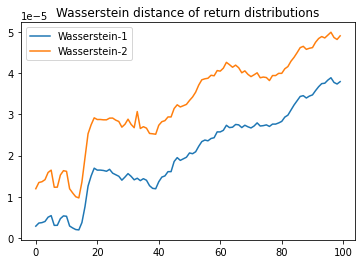

In [49]:
plt.plot(
    eval.wasserstein_vmap(
        results['rets_eval'].T,
        results['rets_gen'].T,
        1
    ),
    label='Wasserstein-1'
)

plt.plot(
    eval.wasserstein_vmap(
        results['rets_eval'].T,
        results['rets_gen'].T,
        2
    ),
    label='Wasserstein-2'
)
plt.title('Wasserstein distance of return distributions')
plt.legend()

In [ ]:
# DONE:

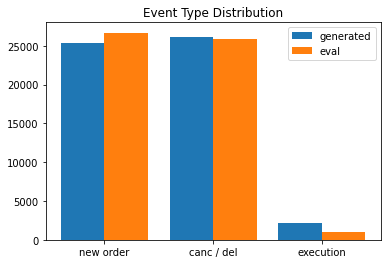

In [32]:
eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    combine_mod = True
)

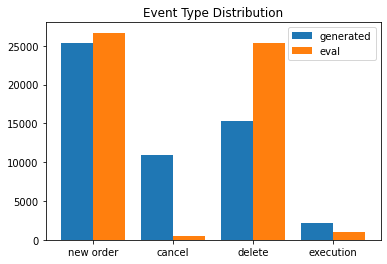

In [31]:
eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    combine_mod = False
)

Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

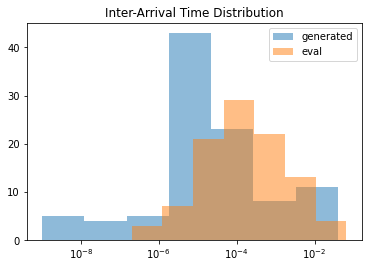

In [ ]:
plot_log_hist(delta_t_gen.flatten(), label='generated')
plot_log_hist(delta_t_eval.flatten(), label='eval')
plt.title('Inter-Arrival Time Distribution')

Text(0.5, 1.0, 'Inter-Arrival Time Distribution')

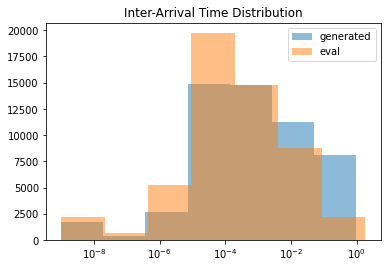

In [24]:
plot_log_hist(results['delta_t_gen'].flatten(), label='generated')
plot_log_hist(results['delta_t_eval'].flatten(), label='eval')
plt.title('Inter-Arrival Time Distribution')

In [25]:
results['delta_t_eval'].flatten().shape

(53600,)

In [26]:
results['delta_t_gen'].flatten().shape

(53600,)

In [153]:
eval.emp_cdf(results['delta_t_gen'].flatten())

(Array([9.9999997e-10, 9.9999997e-10, 9.9999997e-10, ..., 9.6202385e-01,
        9.7234219e-01, 9.8603922e-01], dtype=float32),
 Array([1.8656716e-05, 3.7313432e-05, 5.5970148e-05, ..., 9.9996269e-01,
        9.9998134e-01, 1.0000000e+00], dtype=float32))

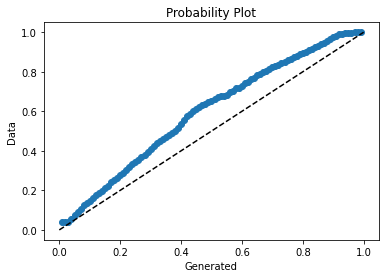

In [154]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)

Text(0.5, 1.0, 'QQ-Plot of Inter-Arrival Time Distribution')

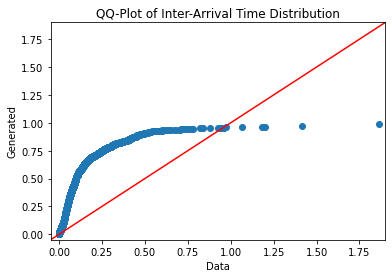

In [155]:
# not that useful due to long tail of the distribution
# --> we see here mostly the tail in the plot which doesn't match well
#     but has only a small number of samples

from statsmodels.graphics.gofplots import qqplot_2samples

_ = qqplot_2samples(
    results['delta_t_eval'].flatten(),
    results['delta_t_gen'].flatten(),
    xlabel='Data',
    ylabel='Generated',
    line='45'
)
plt.title('QQ-Plot of Inter-Arrival Time Distribution')

Text(0, 0.5, 'Wasserstein distance')

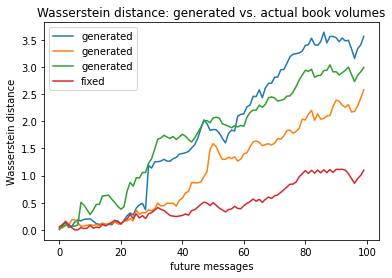

In [46]:
# single data sample

plt.plot(
    onp.arange(book_loss_wass_j.shape[1]),
    book_loss_wass_j.T,
    label='generated'
)
plt.plot(
    book_loss_wass_const,
    label='fixed'
)
plt.legend()
plt.title('Wasserstein distance: generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('Wasserstein distance')

In [ ]:
# note: don't make mistake of comparing MEAN generated returns to realised returns

In [44]:
results['num_errors']

Array([[ 11],
       [ 34],
       [ 20],
       [ 14],
       [ 12],
       [ 24],
       [ 26],
       [ 49],
       [ 22],
       [ 12],
       [ 37],
       [ 13],
       [ 32],
       [ 10],
       [ 16],
       [ 28],
       [ 17],
       [ 27],
       [ 18],
       [ 13],
       [ 20],
       [ 20],
       [ 12],
       [ 14],
       [ 41],
       [ 33],
       [ 27],
       [ 11],
       [ 36],
       [  7],
       [ 20],
       [ 12],
       [ 24],
       [ 12],
       [ 32],
       [ 55],
       [ 14],
       [ 26],
       [ 18],
       [ 23],
       [ 29],
       [ 11],
       [ 34],
       [ 15],
       [ 20],
       [ 11],
       [ 30],
       [ 22],
       [ 15],
       [ 35],
       [ 28],
       [ 14],
       [ 23],
       [ 59],
       [ 23],
       [ 38],
       [ 50],
       [ 20],
       [ 23],
       [ 15],
       [ 23],
       [ 18],
       [ 10],
       [ 11],
       [ 34],
       [112],
       [ 13],
       [ 17],
       [ 24],
       [ 17],
       [ 16],
      

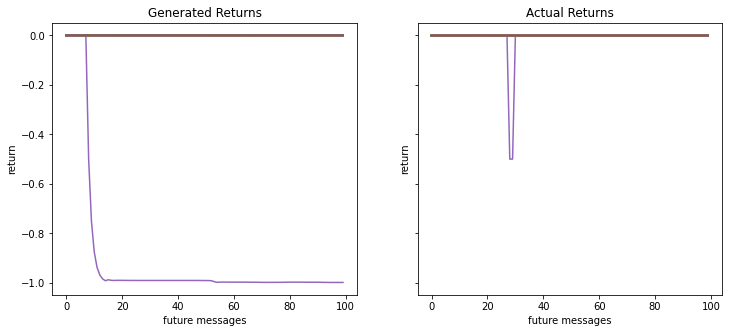

In [28]:
plot_returns(results['rets_gen'], results['rets_eval'])

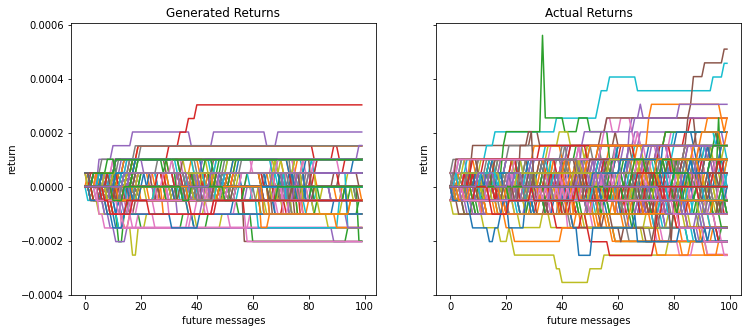

In [160]:
eval.plot_returns(results['rets_gen'], results['rets_eval'])

In [162]:
eval.plot_ret_corr

<function lob.evaluation.plot_ret_corr(rets_gen, rets_eval, ci=None, rng=None)>

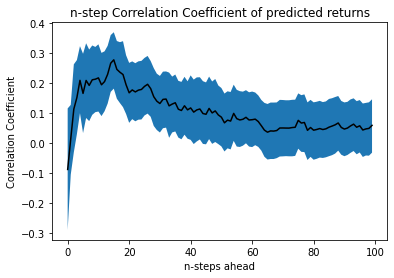

In [164]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(results['rets_gen'], results['rets_eval'], ci=0.95, rng=rng_)

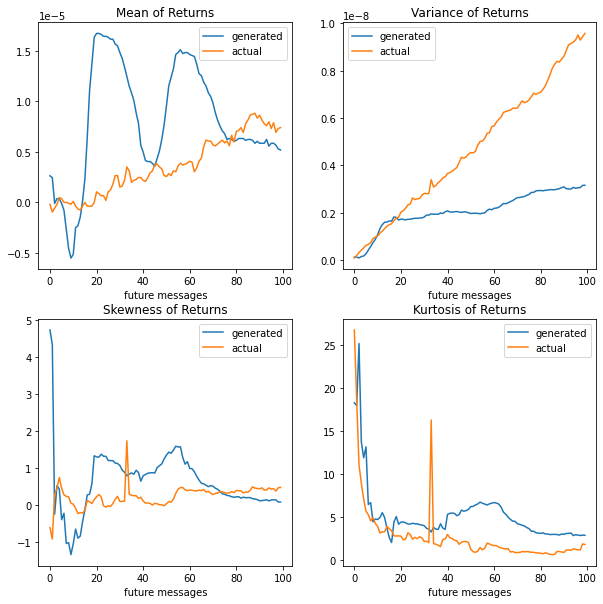

In [165]:
r_gen_mean, r_gen_var, r_gen_skew, r_gen_kurt = eval.calc_moments(results['rets_gen'])
r_eval_mean, r_eval_var, r_eval_skew, r_eval_kurt = eval.calc_moments(results['rets_eval'])

eval.plot_moments(
    r_gen_mean, r_gen_var, r_gen_skew, r_gen_kurt,
    r_eval_mean, r_eval_var, r_eval_skew, r_eval_kurt)

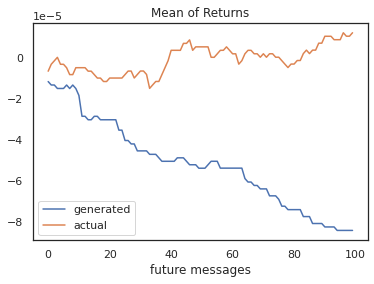

In [85]:
plt.plot(r_gen_mean, label='generated')
plt.plot(r_eval_mean, label='actual')
plt.title('Mean of Returns')
plt.xlabel('future messages')
plt.legend()

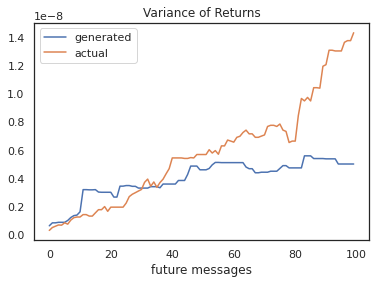

In [86]:
plt.plot(r_gen_var, label='generated')
plt.plot(r_eval_var, label='actual')
plt.title('Variance of Returns')
plt.xlabel('future messages')
plt.legend()

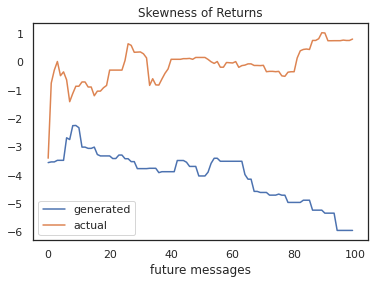

In [87]:
plt.plot(r_gen_skew, label='generated')
plt.plot(r_eval_skew, label='actual')
plt.title('Skewness of Returns')
plt.xlabel('future messages')
plt.legend()

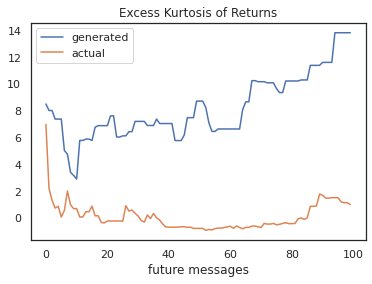

In [88]:
plt.plot(r_gen_kurt, label='generated')
plt.plot(r_eval_kurt, label='actual')
plt.title('Excess Kurtosis of Returns')
plt.xlabel('future messages')
plt.legend()

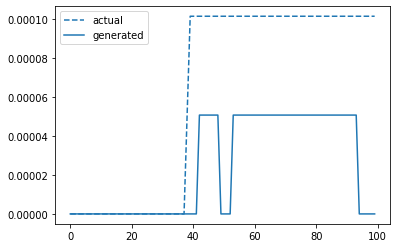

In [89]:
# TODO: plot this for multiple samples

_ = plt.plot(rets_eval.T, linestyle='--', label='actual')
# reset color cycle
plt.gca().set_prop_cycle(None)
_ = plt.plot(rets_gen.T, label='generated')
plt.legend()

Text(0, 0.5, 'Correlation Coefficient')

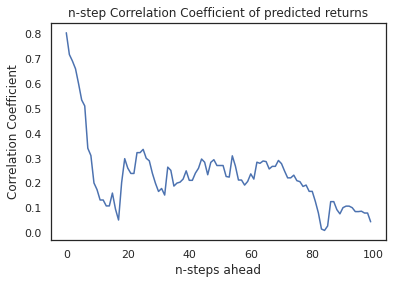

In [93]:
ret_corr = eval.return_corr(rets_gen, rets_eval)
plt.plot(ret_corr)
plt.title('n-step Correlation Coefficient of predicted returns')
plt.xlabel('n-steps ahead')
plt.ylabel('Correlation Coefficient')

In [ ]:
#mid_price_loss_l1(l2_book_states, l2_book_states_eval)

Array([0. , 0. , 0. , 0. , 1. , 1. , 1.5, 1.5, 2.5, 2.5, 2.5, 3. , 3.5,
       3.5, 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4.5, 4.5, 4.5, 5. , 5. ,
       5. , 4.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 4.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5,
       5.5, 5.5, 5.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 6. ,
       6. , 6. , 6. , 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],      dtype=float32, weak_type=True)

Text(0, 0.5, 'mean abs. loss')

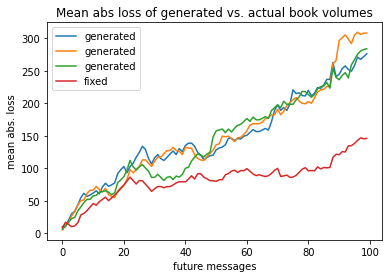

In [24]:
# single data sample

plt.plot(
    onp.arange(book_loss_l1_j.shape[1]),
    book_loss_l1_j.T,
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Mean abs loss of generated vs. actual book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

Text(0, 0.5, 'mean abs. loss')

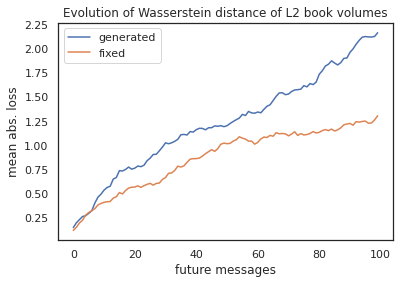

In [104]:
plt.plot(
    book_losses_wass.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_wass_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of Wasserstein distance of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

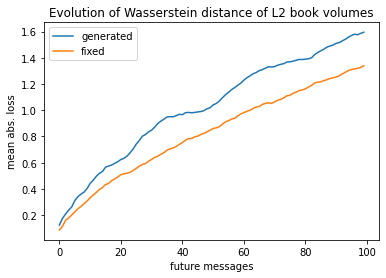

In [166]:
eval.plot_book_losses(
    results['book_losses_wass'],
    results['book_losses_wass_const'],
    'Wasserstein'
)

Text(0, 0.5, 'mean abs. loss')

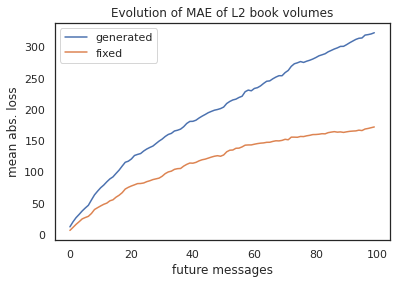

In [105]:
plt.plot(
    book_losses_l1.mean(axis=(0,1)),
    label='generated'
)
plt.plot(
    book_losses_l1_const.mean(axis=0),
    label='fixed'
)
plt.legend()
plt.title('Evolution of MAE of L2 book volumes')
plt.xlabel('future messages')
plt.ylabel('mean abs. loss')

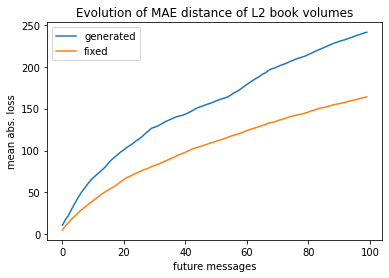

In [167]:
eval.plot_book_losses(
    results['book_losses_l1'],
    results['book_losses_l1_const'],
    'MAE'
)

Text(0, 0.5, 'Squared Error')

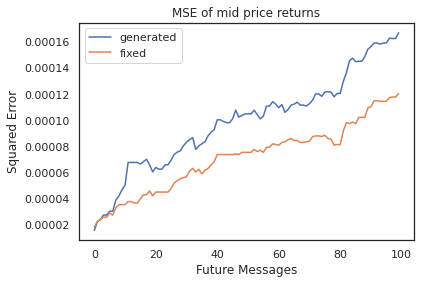

In [106]:
plt.plot(
    jnp.sqrt(mid_ret_errs.mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(mid_ret_errs_const.mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

In [64]:
jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)

(535, 100)

Text(0, 0.5, 'Squared Error')

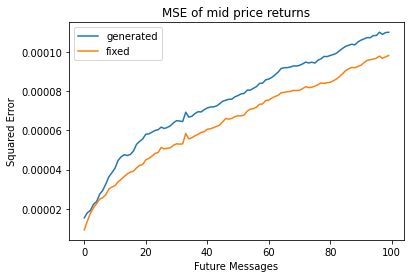

In [168]:
# removed one outlier

plt.plot(
    jnp.sqrt(jnp.square(results['rets_gen'] - results['rets_eval']).mean(axis=0)),
    label='generated'
)
plt.plot(
    jnp.sqrt(jnp.square(results['rets_eval']).mean(axis=0)),
    label='fixed'
)
plt.legend()
plt.title('MSE of mid price returns')
plt.xlabel('Future Messages')
plt.ylabel('Squared Error')

In [169]:
# outlier in data

mid_ret_errs = eval.mid_price_ret_squ_err(
    results['mid_gen'], results['mid_eval'], mid_t0)
# compare to squared error from const prediction
mid_ret_errs_const = jnp.square(rets_eval)

eval.plot_return_mse(
    mid_ret_errs,
    mid_ret_errs_const
)

KeyError: 'mid_gen'

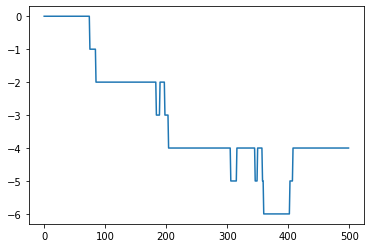

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

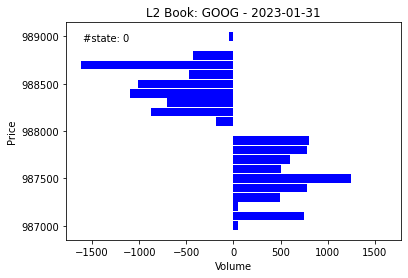

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

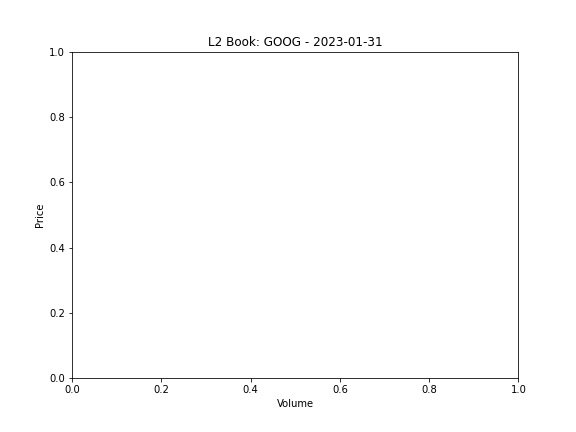

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

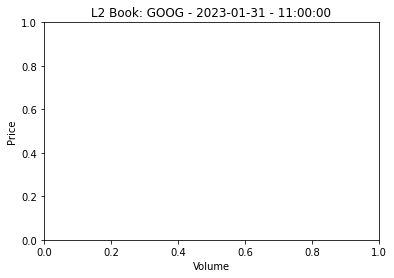

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

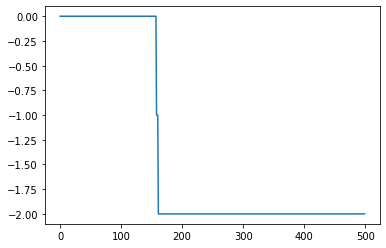

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

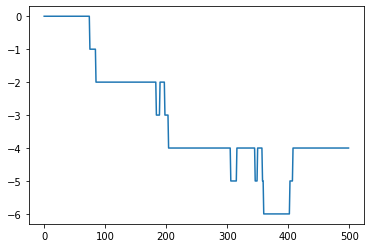

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

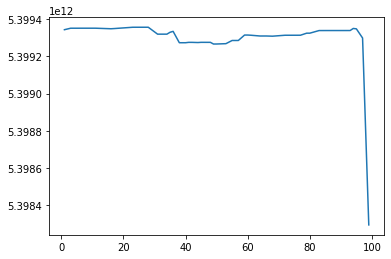

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

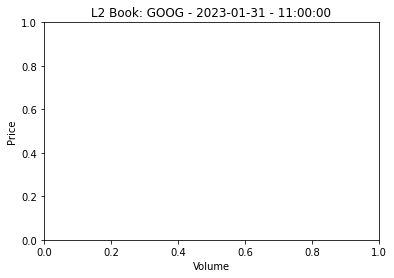

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

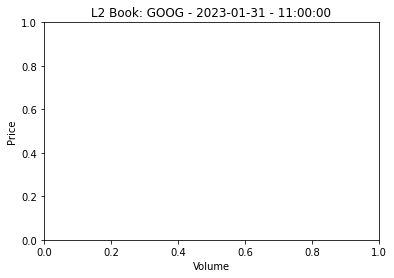

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

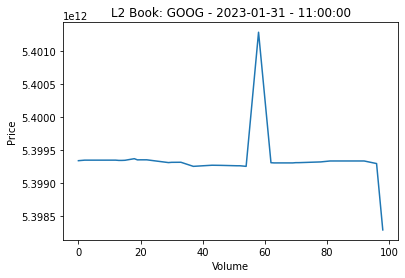

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

### Model Validation (optional)

In [ ]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [ ]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [26]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, par_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

NameError: name 'test_loader' is not defined

In [ ]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [ ]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [ ]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.624236,0.632841,0.626838,436
event_type,0.393960,0.399946,0.396617,465
generic,1.000000,0.998603,0.999301,716
price,0.557158,0.452684,0.477146,676
size,0.213366,0.152106,0.170773,680
time,0.011118,0.037804,0.016177,685
